In [1]:
#  Import relevant libraries

import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
#  Check collected data

# Access raw data

file_path = os.path.expanduser('~/Desktop/PremierLeagueStats.csv')

# Read the CSV file

data = pd.read_csv(file_path)

# Drop the Season End column

data = data.drop('Season End', axis=1)

# Drop the Team column

data = data.drop('Team', axis=1)

# Drop the Average Distance to Away Games column

data = data.drop('Average Distance to Away Games', axis=1)

# Display the first few rows to verify it's loaded correctly

display(data.head())

print("Original data types:")

print(data.dtypes)

,Squad Value,Net Summer Transfer Spend,Retained Manager?,Average Attendance,Wage Bill,Retained Captain?,Previous Season Disciplinary Points,Net Number of Transfers,Previous Season Goal Difference,Previous Season Position,Position Bin,Games Played,Number of Managers employed in the season
0,580750000,71050000,0,59989,135360000,0,67,0,23,6,2,58,1
1,604250000,107150000,1,60279,118540000,0,79,-3,22,5,1,54,2
2,540800000,57140000,1,10000,147450000,1,108,5,8,8,1,54,1
3,521000000,116250000,1,59763,114370000,0,68,4,16,8,2,45,1
4,935000000,144080000,1,60186,101660000,0,72,1,13,5,2,54,1


Original data types:
Squad Value                                  int64
Net Summer Transfer Spend                    int64
Retained Manager?                            int64
Average Attendance                           int64
Wage Bill                                    int64
Retained Captain?                            int64
Previous Season Disciplinary Points          int64
Net Number of Transfers                      int64
Previous Season Goal Difference              int64
Previous Season Position                     int64
Position Bin                                 int64
Games Played                                 int64
Number of Managers employed in the season    int64
dtype: object


In [3]:
#  Preprocessing

# Function to identify problematic columns

def identify_mixed_type_columns(df):
    mixed_type_columns = []
    for column in df.columns:
        if df[column].dtype == 'object':
            try:
                pd.to_numeric(df[column])
            except ValueError:
                if df[column].str.contains(',').any(): 
                    mixed_type_columns.append(column)
    return mixed_type_columns

# Identify problematic columns

problematic_columns = identify_mixed_type_columns(data)
print("Problematic columns:", problematic_columns)

# Handle problematic columns

for column in problematic_columns:
    data[column] = data[column].str.replace(',', '') 
    data[column] = pd.to_numeric(data[column], errors='coerce') 

# Identify numeric and categorical columns

numeric_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

categorical_features = data.select_dtypes(include=['object']).columns.tolist()

# After identifying numeric and categorical features

print("Numeric features:", numeric_features)

print("Categorical features:", categorical_features)

# Create preprocessing steps

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore'))
])

# Check if there are any categorical features

if len(categorical_features) == 0:
    print("No categorical features found. Adjusting preprocessor.")
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features)
        ])
else:
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

# Remove 'Position Bin' from features if it's present

if 'Position Bin' in numeric_features:
    numeric_features.remove('Position Bin')

if 'Position Bin' in categorical_features:
    categorical_features.remove('Position Bin')

# Create preprocessing steps

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

Problematic columns: []
Numeric features: ['Squad Value', 'Net Summer Transfer Spend', 'Retained Manager?', 'Average Attendance', 'Wage Bill', 'Retained Captain?', 'Previous Season Disciplinary Points', 'Net Number of Transfers', 'Previous Season Goal Difference', 'Previous Season Position', 'Position Bin', 'Games Played', 'Number of Managers employed in the season']
Categorical features: []
No categorical features found. Adjusting preprocessor.


In [4]:
# Prepare the features and target

X = data.drop('Position Bin', axis=1)
y = data['Position Bin']

In [5]:
# Encode target variable

le = LabelEncoder()
y = le.fit_transform(y)

In [6]:
# Split the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Fit the preprocessor on the training data and transform both training and test data

X_train_preprocessed = preprocessor.fit_transform(X_train)

X_test_preprocessed = preprocessor.transform(X_test)

In [8]:
# Get feature names after preprocessing

feature_names = numeric_features.copy()
if len(categorical_features) > 0:
    onehot_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
    cat_feature_names = onehot_encoder.get_feature_names_out(categorical_features).tolist()
    feature_names += cat_feature_names


In [9]:
# Convert to DataFrames

X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=feature_names)

X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns=feature_names)

In [10]:
print("Preprocessing complete. Ready for model training.")

print(f"Training set shape: {X_train_preprocessed.shape}")

print(f"Testing set shape: {X_test_preprocessed.shape}")

Preprocessing complete. Ready for model training.
Training set shape: (96, 12)
Testing set shape: (24, 12)


In [11]:
# Display sample of preprocessed features to verify

display("\nSample of preprocessed features (training set):")

display(X_train_preprocessed.head())

'\nSample of preprocessed features (training set):'

,Squad Value,Net Summer Transfer Spend,Retained Manager?,Average Attendance,Wage Bill,Retained Captain?,Previous Season Disciplinary Points,Net Number of Transfers,Previous Season Goal Difference,Previous Season Position,Games Played,Number of Managers employed in the season
0,-0.014788,0.016174,0.56131,0.278806,0.022644,0.690596,-0.788917,-0.078975,-0.687129,-0.295186,-0.709064,-0.603023
1,-0.602514,-0.417240,0.56131,-1.145939,-0.835025,0.690596,-0.458769,0.580297,-0.687129,0.747925,-0.964966,-0.603023
2,-0.742166,-0.330148,0.56131,-0.826905,-1.254789,-1.448024,-0.854947,0.909933,-1.530008,1.791035,-0.581112,-0.603023
3,-0.602443,0.212600,0.56131,-0.121273,-0.937157,-1.448024,0.729766,1.239569,1.401744,-1.512148,0.570450,-0.603023
4,1.031982,-0.121792,0.56131,-1.171406,2.153176,0.690596,0.003439,1.239569,0.925334,-1.164444,1.849963,-0.603023


In [12]:
# Print feature names after preprocessing

print("\nFeature names after preprocessing:")

print(X_train_preprocessed.columns.tolist())


Feature names after preprocessing:
['Squad Value', 'Net Summer Transfer Spend', 'Retained Manager?', 'Average Attendance', 'Wage Bill', 'Retained Captain?', 'Previous Season Disciplinary Points', 'Net Number of Transfers', 'Previous Season Goal Difference', 'Previous Season Position', 'Games Played', 'Number of Managers employed in the season']


In [13]:
# Train a RandomForest model

rf = RandomForestClassifier(random_state=42)

rf.fit(X_train_preprocessed, y_train)

RandomForestClassifier(random_state=42)

In [14]:
# Make predictions

y_pred = rf.predict(X_test_preprocessed)

In [15]:
# Evaluate the model

print("\nClassification Report:")

print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")

print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.92      0.96        12
           2       1.00      1.00      1.00         9

    accuracy                           0.96        24
   macro avg       0.92      0.97      0.94        24
weighted avg       0.97      0.96      0.96        24


Confusion Matrix:
[[ 3  0  0]
 [ 1 11  0]
 [ 0  0  9]]


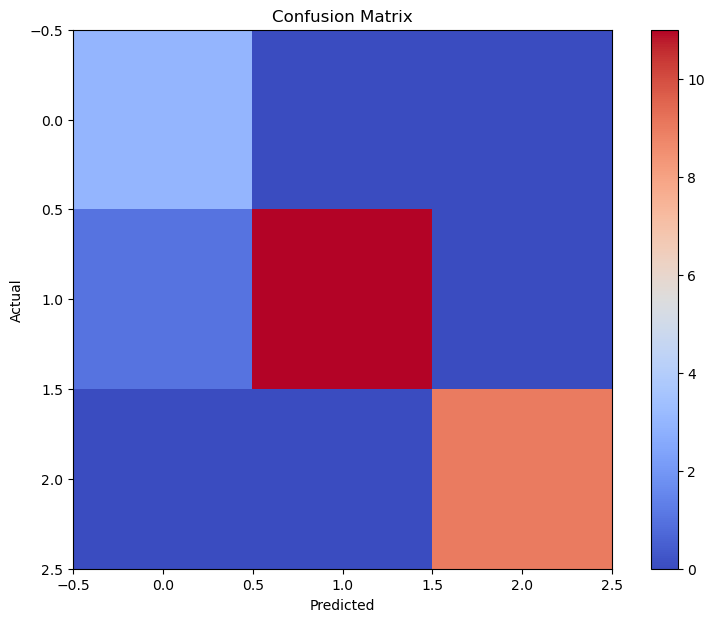

In [16]:
# Visualize the confusion matrix

plt.figure(figsize=(10, 7))
conf_matrix = confusion_matrix(y_test, y_pred)
plt.imshow(conf_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Top 10 Most Important Features:
   Importance                                    Feature
0    0.198235                                Squad Value
1    0.143390                                  Wage Bill
2    0.123374                               Games Played
3    0.103833            Previous Season Goal Difference
4    0.096915                   Previous Season Position
5    0.078987        Previous Season Disciplinary Points
6    0.072779                  Net Summer Transfer Spend
7    0.071042                         Average Attendance
8    0.042149  Number of Managers employed in the season
9    0.041388                    Net Number of Transfers


<Figure size 1000x600 with 0 Axes>

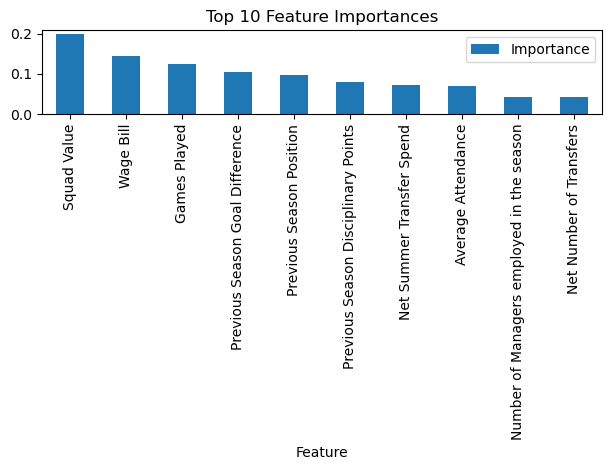

In [17]:
# Get feature importances

importances = rf.feature_importances_
feature_imp = pd.DataFrame(sorted(zip(importances, X_train_preprocessed.columns), reverse=True), 
                           columns=['Importance', 'Feature'])

# Display top 10 most important features

print("\nTop 10 Most Important Features:")

print(feature_imp.head(10))

# Visualize feature importances

plt.figure(figsize=(10, 6))
feature_imp.head(10).plot(x='Feature', y='Importance', kind='bar')
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()